In [1]:
#basics
import numpy as np
import pandas as pd

#viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette='colorblind')

#modules
import wrangle

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


##### Question 5 - At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

Given the timelines mentioned, I was unable to concretely define certain curriculums by program.  This is likely mostly due to treating each program seperately instead of aggregating by full_stack_php, full_stack_java and front_end.  Treating 2020+ data as 'clean', I was able to identify times at which programs had cross-curriculum activity. However, the timelines in the plot do not seem to match with this question, as most of 2019 contained cross-curriculum activity.  Looking into it a little more, it seems that all the registered activity is between full_stack_php and full_stack_java.



In [2]:
def q5_wrangle(old_df):
    df5 = old_df.copy()
    #drop staff access
    df5 = df5[df5.name != 'Staff']
    #drop unknown cohorts
    df5 = df5[~df5.name.isna()]
    #convert date to datetime format
    df5['date'] = pd.to_datetime(df5['date'],format='%Y-%m-%d')
    df5['end_date'] = pd.to_datetime(df5['end_date'],format='%Y-%m-%d')
    #only look at currently active students
    df5 = df5[df5['date'] <= df5['end_date']]
    return df5

def question5_fullpaths(df):
    #do some more wrangling
    df5 = q5_wrangle(df)
    #Get 2020 and later site visits 
    #represents 'clean' data - when students couldn't access each other's curriculum
    df5_rest = df5[df5.date > '2019-12-31']
    
    ############## Section may change if I decide to use the whole path
    #create 'root' paths dataframe - just the first part of the url (after the domain)
    all_paths = pd.DataFrame(df5_rest.path.unique()).rename(columns={0:'path'}) #261
    #loop over each program
    for cnt,p in enumerate(df5.program_name.unique()):
        #create new column name
        col_name = str(p)
        #make subset of root paths accessed by this program
        prog_paths = df5_rest[df5_rest.program_name == p].path
        #create 0/1 column to see if that path was accessed by this program
        all_paths[col_name] = all_paths.path.isin(prog_paths).astype(int)

    #Now aggregate and find columns that only one program ever accessed
    all_paths['only_one'] = (1 == all_paths.loc[:,'full_stack_php':'data_science'].sum(axis=1))
    
    #create dataframe of root paths that only one program has access to
    all_paths_rest = all_paths[all_paths.only_one]
    ##############
    
    ##### Now create dataframe of cross_access logs ####
    cross_access = pd.DataFrame()
    #loop over each program
    for cnt, p in enumerate(df5.program_name.unique()):
        #get entries that don't include that program
        df_not_p = df5[df5.program_name != p]
        #now add any inappropriate access times
        #if the path of any other program, is in that exclusive program's url, then add the line
        subset = df_not_p[df_not_p.path.isin(all_paths_rest[all_paths_rest[p] == 1].path)]
        cross_access = pd.concat([cross_access,subset])

    cross_access.drop_duplicates(inplace=True)
    ##############
    
    ## Plot timeline of 'inappropriate' access
    plt.figure(figsize=(12,6))
    sns.histplot(data=cross_access,x='date',binwidth=14)
    plt.title('Subset of Cross-Curriculum Access Activity',size=14);
    plt.ylabel('Site Visits');
    plt.xlabel('Date');
    print(type(cross_access))
    return cross_access
    

Returning saved csv files.
<class 'pandas.core.frame.DataFrame'>


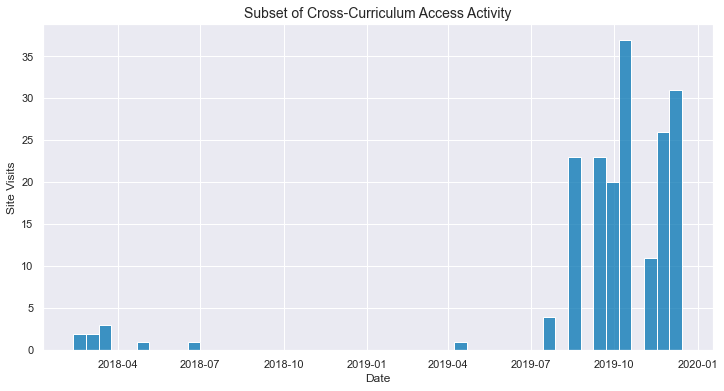

In [3]:
df = wrangle.get_curriculum_data()
cross_access = question5_fullpaths(df)

##### Question 6 - What topics are grads continuing to reference after graduation and into their jobs (for each program)?

- Full stack java and php cohorts accessed these classes most after graduation:
  - Javascript i
  - Html - css
  - spring
- Data Science cohorts accessed these classes most after graduation:
  - Intro to Data Science
    - Note: this was aggregated across multiple naming conventions - likely due to a change in website structure
  - MySQL Overview
  - Classification Overview

*With a greater understanding of the site layout and how the site structure changed in the past, further insights could be provided*

In [4]:
#The Code
def q6_wrangle(old_df):
    df = old_df.copy()
    #Convert these columns to datetimes
    df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
    df['start_date'] = pd.to_datetime(df['start_date'],format='%Y-%m-%d')
    df['end_date'] = pd.to_datetime(df['end_date'],format='%Y-%m-%d')
    #filter dataset down to just post-graduation visits
    df = df[df.date > df.end_date]
    #get a days after graduation column
    df['days_post_grad'] = (df['date'] - df['end_date']).astype('timedelta64[D]')
    #drop entry points ('/','index.html' and 'search/search_index.json')
    df = df[(df.path != '/') & (df.path != 'search/search_index.json') & (df.path != 'index.html')]
    #also drop images
    df = df[~(df.path.str.endswith('.jpg')) & ~(df.path.str.endswith('.jpeg')) & ~(df.path.str.endswith('.svg'))]
    return df
def question6(df):
    #do some more wrangling
    df6 = q6_wrangle(df)
    #Plot most popular websites:
    plt.figure(figsize=(10,25))
    colors = sns.color_palette('colorblind').as_hex()
    # length = len(df.program_name.nunique())
    #loop over each program
    cnt=1
    for p in df6.program_name.unique():
        if p == 'front_end': continue
        #get subset of site visits for this program
        df_prog = df6[df6.program_name == p]
        #get top visits
        df_prog_top = pd.DataFrame(df_prog.path.value_counts()).rename(columns={'path':'count'})
        df_prog_top['path'] = df_prog_top.index
        #plot top 10 visits per program
        plt.subplot(3,1,cnt)
        plt.title(f'Top 10 site visits for {p}',size=14);
        sns.barplot(y = 'path', x = 'count',data= df_prog_top.head(10), orient = 'h',color=colors[cnt]);
        plt.xlabel('Number of post-graduation site visits');
        cnt+=1
    return None

Returning saved csv files.


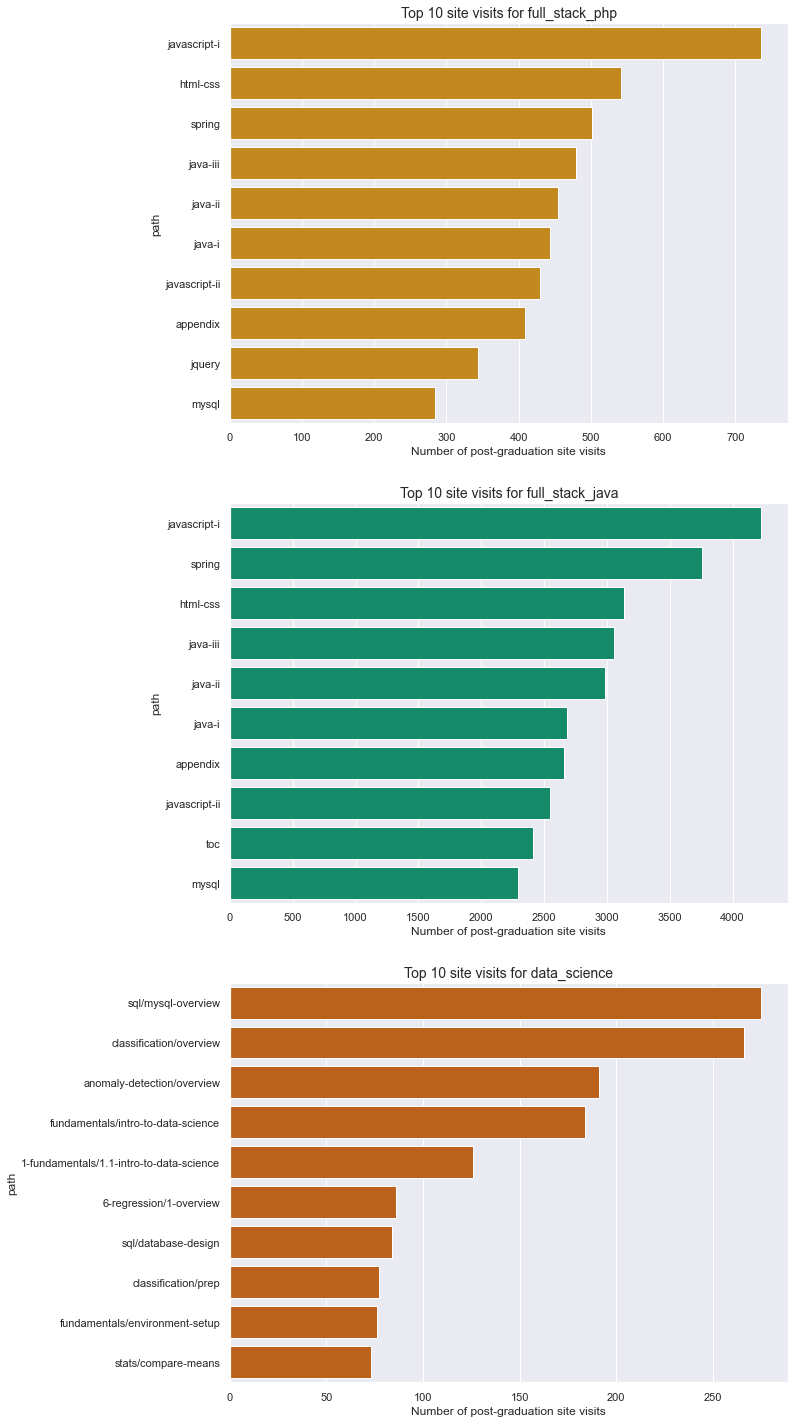

In [5]:
#Run me
df = wrangle.get_curriculum_data()
question6(df)